In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from glob import glob
import os

import warnings
warnings.filterwarnings('ignore')

# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
filenames = glob('./Neuromarketing/25-users/*.txt')
brainwave = [pd.read_csv(f, sep = "\ ",header=None) for f in filenames]

NumofHuman = 1045
NumofChannel = 14
Time = 512

brainwave_NP = np.zeros((NumofHuman,Time,NumofChannel)) ###사람, signal, channel
for i in range(NumofHuman):
    brainwave_NP[i] = brainwave[i].to_numpy()

In [3]:
filenames = glob('./Neuromarketing/labels/*.lab')
labelList = pd.DataFrame()

for f in filenames:
    label = pd.read_csv(f, sep = "\ ",header=None)
    label = label.T
    labelList = labelList.append(label)

labelList.columns = ["Label"]
labelList_NP = np.zeros((NumofHuman))
labelList_NP = labelList.to_numpy()

labelList_NP_int = np.zeros((len(labelList_NP),1))
for i in range(len(labelList_NP)):
    labelList_NP_int[i] = int(labelList_NP[i] == 'Like')

In [4]:
brainwave_NP.shape, labelList_NP_int.shape

((1045, 512, 14), (1045, 1))

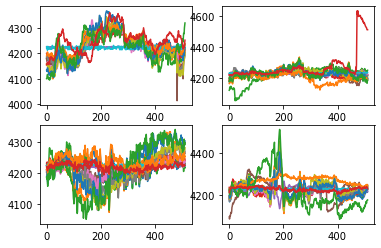

In [5]:
plt.subplot(2,2,1)
for i in range(NumofChannel):
    plt.plot(brainwave_NP[1][:,i])
    
plt.subplot(2,2,2)
for i in range(NumofChannel):
    plt.plot(brainwave_NP[100][:,i])
    
plt.subplot(2,2,3)
for i in range(NumofChannel):
    plt.plot(brainwave_NP[500][:,i])
    
plt.subplot(2,2,4)
for i in range(NumofChannel):
    plt.plot(brainwave_NP[800][:,i])

plt.show()

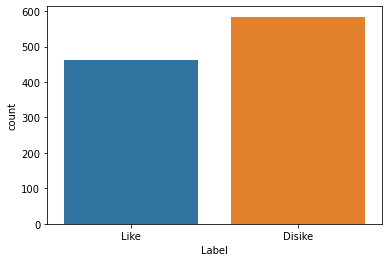

In [6]:
ax = sns.countplot(labelList.Label)

In [7]:
brainwave_NP_AvgV1 = np.zeros((len(brainwave_NP), 512))
for i in range(NumofHuman):
    brainwave_NP_AvgV1[i] = brainwave_NP[i].mean(axis = 1)
    
brainwave_NP_AvgV1.shape

(1045, 512)

In [8]:
trainXX, testXX, trainy, testy = train_test_split(brainwave_NP_AvgV1, labelList_NP_int, test_size = 0.1, shuffle=True, random_state = 42)

In [9]:
%%time

pl_random_forest = Pipeline(steps=[('random_forest', RandomForestClassifier())])
model1 = pl_random_forest.fit(trainXX,trainy)
scores = cross_val_score(pl_random_forest, trainXX, trainy, cv=10,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

Accuracy for RandomForest :  0.5287234042553192
Wall time: 8.71 s


In [10]:
%%time
pl_log_reg = Pipeline(steps=[('scaler',StandardScaler()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=200))])
model2 = pl_log_reg.fit(trainXX,trainy)
scores = cross_val_score(pl_log_reg, trainXX, trainy, cv=10,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

Accuracy for Logistic Regression:  0.5414893617021276
Wall time: 10.4 s


In [11]:
%%time

pl_svm = Pipeline(steps=[('scaler',StandardScaler()),
                             ('pl_svm', LinearSVC())])
model3 = pl_svm.fit(trainXX,trainy)
scores = cross_val_score(pl_svm, trainXX,trainy, cv=10,scoring='accuracy')
print('Accuracy for Linear SVM : ', scores.mean())

Accuracy for Linear SVM :  0.48829787234042554
Wall time: 12.5 s


In [12]:
from sklearn.metrics import accuracy_score
y_predict = model2.predict(testXX)
accuracy_score(testy, y_predict)

0.5428571428571428

# LSTM 사용하기

In [13]:
trainX_float, testX_float, trainy, testy = train_test_split(brainwave_NP, labelList_NP_int, test_size = 0.1, shuffle=True, random_state = 42)

In [14]:
trainX = trainX_float.astype(int)
testX = testX_float.astype(int)

In [15]:
trainX.shape, testX.shape, trainy.shape, testy.shape

((940, 512, 14), (105, 512, 14), (940, 1), (105, 1))

In [16]:
verbose, epochs, batch_size = 0, 15, 256
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [17]:
%%time
# fit and evaluate a model
def evaluate_model1(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
scores = list()
for r in range(2):
	score = evaluate_model1(trainX, trainy, testX, testy)
	score = score * 100.0

	scores.append(score)
# summarize results
summarize_results(scores)

[54.28571701049805, 54.28571701049805]
Accuracy: 54.286% (+/-0.000)
Wall time: 16.9 s


Convolutional layer와 LSTM 같이 사용

In [18]:
%%time
# fit and evaluate a model
def evaluate_model2(trainX, trainy, testX, testy):
	# define model
	verbose, epochs, batch_size = 0, 25, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape into subsequences (samples, time steps, rows, cols, channels)
	n_steps, n_length = 4, 128
	trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
	testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
scores = list()
for r in range(2):
	score = evaluate_model2(trainX, trainy, testX, testy)
	score = score * 100.0

	scores.append(score)
# summarize results
summarize_results(scores)

[54.28571701049805, 54.28571701049805]
Accuracy: 54.286% (+/-0.000)
Wall time: 25.3 s


# channel 평균 구해서 대입

In [19]:
brainwave_NP_Avg = np.zeros((1045,512,1))
for i in range(NumofHuman) :
    brainwave_NP_Avg[i][:,0] = brainwave_NP[i].mean(axis =1)
brainwave_NP_Avg.shape

(1045, 512, 1)

In [20]:
trainX_float, testX_float, trainy, testy = train_test_split(brainwave_NP_Avg, labelList_NP_int, test_size = 0.1, shuffle=True, random_state = 42)

In [21]:
trainX = trainX_float.astype(int)
testX = testX_float.astype(int)

In [22]:
trainX.shape, testX.shape, trainy.shape, testy.shape

((940, 512, 1), (105, 512, 1), (940, 1), (105, 1))

In [23]:
verbose, epochs, batch_size = 0, 15, 256
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [33]:
%%time
# fit and evaluate a model
def evaluate_model3(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=False)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
scores = list()
for r in range(2):
	score = evaluate_model3(trainX, trainy, testX, testy)
	score = score * 100.0

	scores.append(score)
# summarize results
summarize_results(scores)

[54.28571701049805, 54.28571701049805]
Accuracy: 54.286% (+/-0.000)
Wall time: 14.3 s


# 특정 채널 사용

In [34]:
brainwave_NP_ch = np.zeros((1045,512,1))
for i in range(NumofHuman) :
    brainwave_NP_ch[i][:,0] = brainwave_NP[i][:,3]
brainwave_NP_ch.shape

(1045, 512, 1)

In [35]:
trainX_float, testX_float, trainy, testy = train_test_split(brainwave_NP_ch, labelList_NP_int, test_size = 0.1, shuffle=True, random_state = 42)

In [36]:
trainX = trainX_float.astype(int)
testX = testX_float.astype(int)

In [37]:
verbose, epochs, batch_size = 0, 15, 256
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [38]:
%%time
# fit and evaluate a model
def evaluate_model4(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
scores = list()
for r in range(2):
	score = evaluate_model4(trainX, trainy, testX, testy)
	score = score * 100.0

	scores.append(score)
# summarize results
summarize_results(scores)

[54.28571701049805, 45.71428596973419]
Accuracy: 50.000% (+/-4.286)
Wall time: 14.5 s
